In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load dataset
df = pd.read_csv("lstm_ready_traffic_data.csv")
scaler = MinMaxScaler()
df['scaled_traffic_volume'] = scaler.fit_transform(df[['Total_Traffic_Volume']])
# If 'day_of_week' is text, convert to numeric
if df['day_of_week'].dtype == 'object':
    df['day_of_week'] = df['day_of_week'].astype('category').cat.codes

# Select features and target
features = ['hour', 'day_of_week', 'month', 'year', 'road_name_encoded',
            'location_encoded', 'suburb_encoded', 'average_speed',
            'maximum_speed', 'Speeding_Incident', 'Speeding_Incident_Avg_Speed']
target = 'scaled_traffic_volume'

# Convert features and target to float32 (required by LSTM)
X = df[features].values.astype('float32')
y = df[target].values.astype('float32')

# Create sequences
def create_sequences(X, y, time_steps=48):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Build the LSTM model
model_multi = Sequential()
model_multi.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_multi.add(Dropout(0.2))
model_multi.add(LSTM(32, activation='relu'))
model_multi.add(Dropout(0.2))
model_multi.add(Dense(1))
model_multi.compile(optimizer='adam', loss='mse')
model_multi.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - loss: 369316.4688 - val_loss: 695.2455
Epoch 2/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - loss: 3427.6150 - val_loss: 32.5116
Epoch 3/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - loss: 1215.5200 - val_loss: 506.6857
Epoch 4/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - loss: 338.1078 - val_loss: 130.2845
Epoch 5/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 220.0709 - val_loss: 59.6288
Epoch 6/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - loss: 157.7496 - val_loss: 25.6853
Epoch 7/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - loss: 134.5150 - val_loss: 18.3880
Epoch 8/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 116.5225 - val_loss: 29.3455
Epoch 9/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - loss: 64.4875 - val_loss: 101.3556
Epoch 10/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 75.0597 - val_loss: 0.5349
Epoch 11/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 22.6070 - val_loss: 

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict
y_pred_multi = model_multi.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_multi))
mae = mean_absolute_error(y_test, y_pred_multi)
r2 = r2_score(y_test, y_pred_multi)
mse = mean_squared_error(y_test, y_pred_multi)

# Results
print("\n✅ Two-Layer LSTM + Dropout (with EarlyStopping and window size 48):")
print(f"🔹 RMSE: {rmse:.4f}")
print(f"🔹 MAE : {mae:.4f}")
print(f"🔹 R²  : {r2:.4f}")
print(f"🔹 MSE : {mse:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step

✅ Two-Layer LSTM + Dropout (with EarlyStopping and window size 48):
🔹 RMSE: 0.4624
🔹 MAE : 0.1789
🔹 R²  : -26.5059
🔹 MSE : 0.2138


<ipython-input-5-97282268e2ca>:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


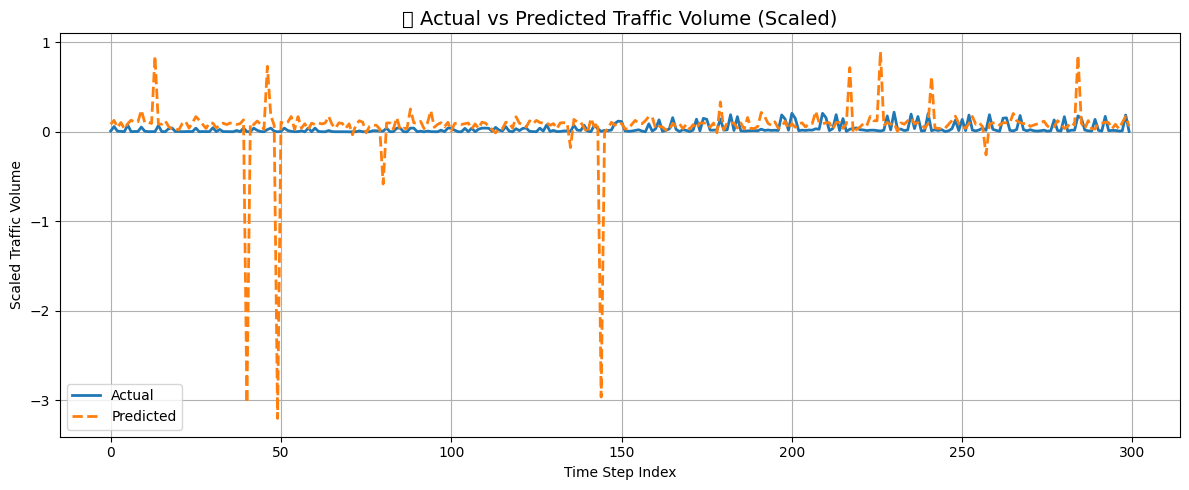

In [5]:
import matplotlib.pyplot as plt

# Plot first 300 predictions for visual clarity
plt.figure(figsize=(12, 5))
plt.plot(y_test[:300], label='Actual', linewidth=2)
plt.plot(y_pred_multi[:300], label='Predicted', linewidth=2, linestyle='--')
plt.title('📊 Actual vs Predicted Traffic Volume (Scaled)', fontsize=14)
plt.xlabel('Time Step Index')
plt.ylabel('Scaled Traffic Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-6-97282268e2ca>:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


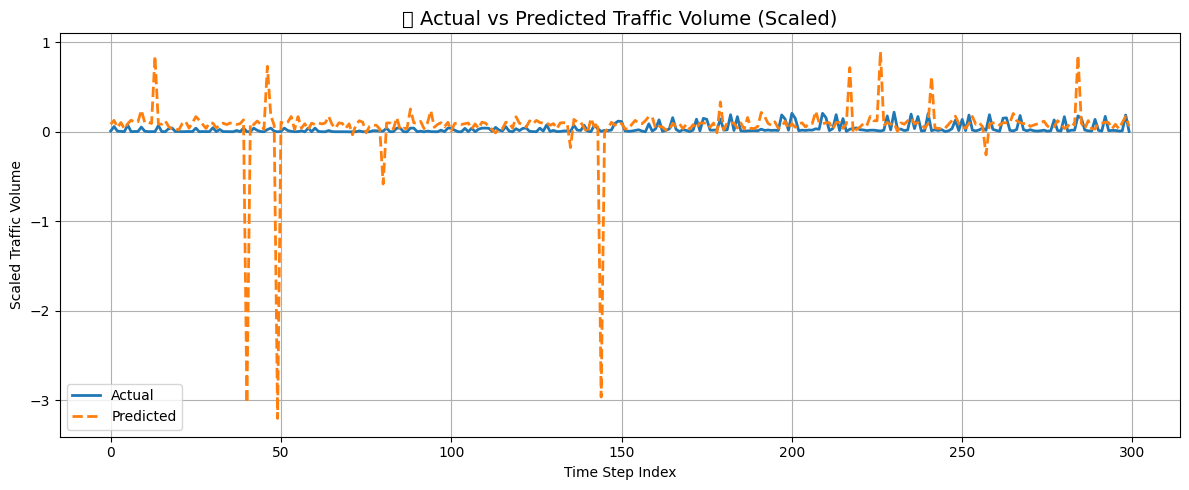

In [6]:
import matplotlib.pyplot as plt

# Plot first 300 predictions for visual clarity
plt.figure(figsize=(12, 5))
plt.plot(y_test[:300], label='Actual', linewidth=2)
plt.plot(y_pred_multi[:300], label='Predicted', linewidth=2, linestyle='--')
plt.title('📊 Actual vs Predicted Traffic Volume (Scaled)', fontsize=14)
plt.xlabel('Time Step Index')
plt.ylabel('Scaled Traffic Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',      # Watch validation loss
    patience=5,              # Stop after 3 epochs without improvement
    restore_best_weights=True  # Revert to best weights
)

In [13]:
from tensorflow.keras.layers import Bidirectional
bilstm_model = Sequential()

bilstm_model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(32, activation='relu')))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(1))

# Compile
bilstm_model.compile(optimizer='adam', loss='mse')

# Train
bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64, callbacks=[early_stop], verbose=1)


Epoch 1/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 60s 70ms/step - loss: 8631096320.0000 - val_loss: 52242.2500
Epoch 2/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 55s 69ms/step - loss: 2395726.5000 - val_loss: 4881.5542
Epoch 3/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - loss: 111942.7188 - val_loss: 4133.1865
Epoch 4/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 56s 70ms/step - loss: 16963.9473 - val_loss: 544.1981
Epoch 5/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 83s 72ms/step - loss: 8295.8379 - val_loss: 19468.0215
Epoch 6/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - loss: 3358.5266 - val_loss: 23366.5859
Epoch 7/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - loss: 10870.4912 - val_loss: 4089.3677
Epoch 8/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - loss: 11630.0186 - val_loss: 11576.1768
Epoch 9/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - loss: 2686.5098 - val_loss: 13411.4854


In [15]:
# Predict
y_pred_bilstm = bilstm_model.predict(X_test)

# Metrics
rmse_bi = np.sqrt(mean_squared_error(y_test, y_pred_bilstm))
mae_bi = mean_absolute_error(y_test, y_pred_bilstm)
r2_bi = r2_score(y_test, y_pred_bilstm)
mse_bi = mean_squared_error(y_test, y_pred_bilstm)

# Results
print("\n✅ Bidirectional LSTM Model Results:")
print(f"🔹 RMSE: {rmse_bi:.4f}")
print(f"🔹 MAE : {mae_bi:.4f}")
print(f"🔹 R²  : {r2_bi:.4f}")
print(f"🔹 MSE : {mse_bi:.4f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step

✅ Bidirectional LSTM Model Results:
🔹 RMSE: 23.3281
🔹 MAE : 20.4071
🔹 R²  : -70007.9688
🔹 MSE : 544.1992


In [16]:
from tensorflow.keras.layers import Bidirectional
tribilstm_model = Sequential()
tribilstm_model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
tribilstm_model.add(Dropout(0.2))
tribilstm_model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
tribilstm_model.add(Dropout(0.2))
tribilstm_model.add(Bidirectional(LSTM(32, activation='relu')))
tribilstm_model.add(Dropout(0.2))
tribilstm_model.add(Dense(1))

# Compile
bilstm_model.compile(optimizer='adam', loss='mse')

# Train
bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64, callbacks=[early_stop], verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 73s 86ms/step - loss: 6293.7085 - val_loss: 23.9748
Epoch 2/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - loss: 37.0402 - val_loss: 0.3178
Epoch 3/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - loss: 6.4384 - val_loss: 0.2081
Epoch 4/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 80s 77ms/step - loss: 2.2302 - val_loss: 0.1833
Epoch 5/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - loss: 2.2110 - val_loss: 0.0726
Epoch 6/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 83s 78ms/step - loss: 1.0158 - val_loss: 0.0622
Epoch 7/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - loss: 0.4915 - val_loss: 0.0247
Epoch 8/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 79s 76ms/step - loss: 0.4634 - val_loss: 0.0142
Epoch 9/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - loss: 0.1621 - val_loss: 0.0149
Epoch 10/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - loss: 0.0546 - val_loss: 0.0092
Epoch 11/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 83s 77ms/step - loss: 32.4784 - val_loss: 0.0207
Epoch 12/30
789/789 ━━━━